In [34]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile, quantum_info, visualization
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from numpy import pi
import random

from qiskit_textbook.problems import dj_problem_oracle

In [56]:
def oracle(qc, xReg, yReg, balanced=False):
    # We do not have to do anything if the function is constant
    if (balanced):
        for i in range(0, len(xReg)):
            qc.cx(xReg[i], yReg)
            
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

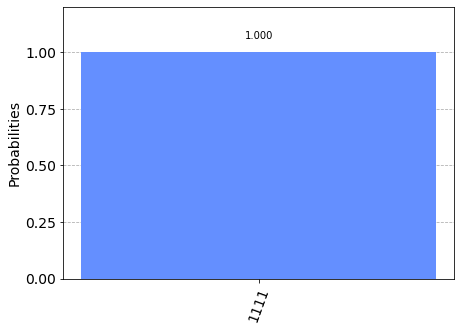

In [58]:
# Creating the neccesary registers
size = 4
xReg = QuantumRegister(size, name="x")
yReg = QuantumRegister(1, name="y")
output = ClassicalRegister(size, name="o")
qc = QuantumCircuit(xReg, yReg, output)

# Prepare |y> = |1>
qc.x(yReg)
qc.barrier()

# Apply Hadamard gate to all |x> and |y>
qc.h(xReg)
qc.h(yReg)
qc.barrier()

# Apply the oracle
oracle(qc, xReg, yReg, True)
qc.barrier()

# Apply Hadamard gates to |x>
qc.h(xReg)
qc.barrier()

# Measure |x>. If balanced will not measure |0>, if constant will only measure |0>
qc.measure(xReg, output)

# Run the simulator
sim = Aer.get_backend('aer_simulator')
circ = transpile(qc, sim)
result = sim.run(circ).result()
counts = result.get_counts()
plot_histogram(counts)